In [4]:
import pandas as pd
import numpy as np
import pathlib
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Configuración inicial
BASE_DIR = pathlib.Path.cwd().parent.resolve()
DATA_DIR = BASE_DIR / 'data'
CLEAN_DATA_DIR = DATA_DIR / 'clean_data'
CORPUS_DIR = DATA_DIR / 'corpus_limpio'

# Descargar recursos NLTK silenciosamente
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
class DataLoader:
    """Cargador de datos para experimentos de clasificación de noticias"""
    
    def __init__(self, data_path: pathlib.Path):
        self.data_path = data_path
        self.df = None
        self.X = None
        self.y = None
    
    def load_dataset(self) -> Tuple[pd.Series, pd.Series]:
        """Carga el dataset y prepara las variables X e y"""
        try:
            self.df = pd.read_csv(self.data_path)
            self.X = self.df["text"].astype(str)
            self.y = self.df["label"].astype(int)
            return self.X, self.y
        except FileNotFoundError:
            raise FileNotFoundError(f"No se encontró el archivo: {self.data_path}")
        except Exception as e:
            raise Exception(f"Error al cargar el dataset: {e}")
    
    def get_dataset_info(self) -> Dict[str, int]:
        """Obtiene información básica del dataset"""
        if self.df is None:
            return {}
        
        return {
            'total_samples': len(self.df),
            'positive_samples': sum(self.y == 1),
            'negative_samples': sum(self.y == 0),
            'features': len(self.df.columns)
        }

# Cargar datos
loader = DataLoader(CORPUS_DIR / 'noticias_combinadas.csv')
X, y = loader.load_dataset()
dataset_info = loader.get_dataset_info()

# Mostrar información del dataset
print(f"Dataset cargado: {dataset_info['total_samples']} muestras")
print(f"Distribución: {dataset_info['negative_samples']} negativos, {dataset_info['positive_samples']} positivos")

Dataset cargado: 5518 muestras
Distribución: 2679 negativos, 2839 positivos


In [6]:
class TextPreprocessor:
    """Preprocesador de texto con opciones de stopwords y stemming"""
    
    def __init__(self, language: str = 'spanish'):
        self.language = language
        self.stopwords = set(stopwords.words(language))
        self.stemmer = SnowballStemmer(language)
    
    def preprocess_texts(self, texts: pd.Series, remove_stopwords: bool = False, 
                        apply_stemming: bool = False) -> List[str]:
        """Preprocesa una serie de textos aplicando las transformaciones especificadas"""
        processed_texts = []
        
        for text in texts:
            if pd.isna(text):
                processed_texts.append("")
                continue
            
            tokens = str(text).split()
            
            if remove_stopwords:
                tokens = [token for token in tokens if token not in self.stopwords]
            
            if apply_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            
            processed_texts.append(" ".join(tokens))
        
        return processed_texts
    
    def get_preprocessing_config(self, remove_stopwords: bool, apply_stemming: bool) -> str:
        """Genera una descripción de la configuración de preprocesamiento"""
        config_parts = []
        if remove_stopwords:
            config_parts.append("sin stopwords")
        if apply_stemming:
            config_parts.append("con stemming")
        
        if not config_parts:
            return "texto original"
        return ", ".join(config_parts)

# Inicializar preprocesador
preprocessor = TextPreprocessor()

In [7]:
class ExperimentConfig:
    """Configurador de experimentos de machine learning"""
    
    def __init__(self):
        self.preprocessing_configs = self._create_preprocessing_configs()
        self.models = self._create_models()
        self.vectorizers = self._create_vectorizers()
    
    def _create_preprocessing_configs(self) -> List[Tuple[str, bool, bool]]:
        """Define las configuraciones de preprocesamiento a evaluar"""
        return [
            ("CountVectorizer", False, False),
            ("CountVectorizer", True, False),
            ("CountVectorizer", False, True),
            ("CountVectorizer", True, True),
            ("TF-IDF", False, False),
            ("TF-IDF", True, False),
            ("TF-IDF", False, True),
            ("TF-IDF", True, True),
        ]
    
    def _create_models(self) -> Dict[str, object]:
        """Define los modelos de machine learning a evaluar"""
        return {
            "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
            "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
            "K-Vecinos": KNeighborsClassifier(),
            "SVM Lineal": SVC(kernel="linear", random_state=42)
        }
    
    def _create_vectorizers(self) -> Dict[str, object]:
        """Define los vectorizadores disponibles"""
        return {
            "CountVectorizer": CountVectorizer(),
            "TF-IDF": TfidfVectorizer()
        }
    
    def get_vectorizer(self, vectorizer_name: str) -> object:
        """Obtiene una instancia nueva del vectorizador especificado"""
        if vectorizer_name == "CountVectorizer":
            return CountVectorizer()
        elif vectorizer_name == "TF-IDF":
            return TfidfVectorizer()
        else:
            raise ValueError(f"Vectorizador no reconocido: {vectorizer_name}")

# Inicializar configuración de experimentos
config = ExperimentConfig()

In [8]:
class ModelEvaluator:
    """Evaluador de modelos con validación cruzada estratificada"""
    
    def __init__(self, n_splits: int = 10, random_state: int = 42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.results = []
    
    def evaluate_model(self, X_vectorized, y: pd.Series, model, model_name: str, 
                      config_id: int, vectorizer_name: str, remove_stopwords: bool, 
                      apply_stemming: bool) -> Dict[str, float]:
        """Evalúa un modelo usando validación cruzada estratificada"""
        metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        
        for train_idx, test_idx in self.skf.split(X_vectorized, y):
            X_train, X_test = X_vectorized[train_idx], X_vectorized[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['precision'].append(precision_score(y_test, y_pred))
            metrics['recall'].append(recall_score(y_test, y_pred))
            metrics['f1'].append(f1_score(y_test, y_pred))
        
        # Calcular promedios
        avg_metrics = {metric: np.mean(scores) for metric, scores in metrics.items()}
        
        # Almacenar resultado
        result = {
            "Config_ID": config_id,
            "Vectorizador": vectorizer_name,
            "Stopwords": remove_stopwords,
            "Stemming": apply_stemming,
            "Algoritmo": model_name,
            "Accuracy": avg_metrics['accuracy'],
            "Precision": avg_metrics['precision'],
            "Recall": avg_metrics['recall'],
            "F1-Score": avg_metrics['f1']
        }
        
        self.results.append(result)
        return avg_metrics
    
    def run_experiments(self, X: pd.Series, y: pd.Series, preprocessor: TextPreprocessor, 
                       config: ExperimentConfig) -> pd.DataFrame:
        """Ejecuta todos los experimentos configurados"""
        self.results = []
        total_experiments = len(config.preprocessing_configs) * len(config.models)
        current_experiment = 0
        
        for config_id, (vectorizer_name, remove_stopwords, apply_stemming) in enumerate(config.preprocessing_configs, 1):
            # Preprocesar textos
            X_processed = preprocessor.preprocess_texts(X, remove_stopwords, apply_stemming)
            
            # Vectorizar
            vectorizer = config.get_vectorizer(vectorizer_name)
            X_vectorized = vectorizer.fit_transform(X_processed)
            
            for model_name, model in config.models.items():
                current_experiment += 1
                
                # Evaluar modelo
                self.evaluate_model(
                    X_vectorized, y, model, model_name, config_id,
                    vectorizer_name, remove_stopwords, apply_stemming
                )
        
        return pd.DataFrame(self.results)
    
    def get_results_dataframe(self) -> pd.DataFrame:
        """Retorna los resultados como DataFrame"""
        return pd.DataFrame(self.results)

# Ejecutar experimentos
evaluator = ModelEvaluator()
results_df = evaluator.run_experiments(X, y, preprocessor, config)

# Mostrar resumen de resultados
print(f"Experimentos completados: {len(results_df)} combinaciones")
print(f"Mejor F1-Score: {results_df['F1-Score'].max():.4f}")
print(f"Algoritmo con mejor F1-Score: {results_df.loc[results_df['F1-Score'].idxmax(), 'Algoritmo']}")

Experimentos completados: 32 combinaciones
Mejor F1-Score: 0.9358
Algoritmo con mejor F1-Score: Regresión Logística


In [9]:
class ResultsManager:
    """Gestor de resultados de experimentos"""
    
    def __init__(self, output_dir: pathlib.Path):
        self.output_dir = output_dir
        self.output_dir.mkdir(parents=True, exist_ok=True)
    
    def save_results(self, results_df: pd.DataFrame, filename: str = "resultados_experimentos.csv") -> pathlib.Path:
        """Guarda los resultados en un archivo CSV"""
        output_path = self.output_dir / filename
        results_df.to_csv(output_path, index=False, encoding='utf-8')
        return output_path
    
    def get_best_results_summary(self, results_df: pd.DataFrame) -> Dict[str, str]:
        """Obtiene un resumen de los mejores resultados"""
        best_f1_idx = results_df['F1-Score'].idxmax()
        best_accuracy_idx = results_df['Accuracy'].idxmax()
        
        return {
            'best_f1_score': f"{results_df.loc[best_f1_idx, 'F1-Score']:.4f}",
            'best_f1_algorithm': results_df.loc[best_f1_idx, 'Algoritmo'],
            'best_f1_config': f"Vectorizador: {results_df.loc[best_f1_idx, 'Vectorizador']}, "
                             f"Stopwords: {results_df.loc[best_f1_idx, 'Stopwords']}, "
                             f"Stemming: {results_df.loc[best_f1_idx, 'Stemming']}",
            'best_accuracy': f"{results_df.loc[best_accuracy_idx, 'Accuracy']:.4f}",
            'best_accuracy_algorithm': results_df.loc[best_accuracy_idx, 'Algoritmo']
        }
    
    def display_summary(self, results_df: pd.DataFrame):
        """Muestra un resumen de los resultados"""
        summary = self.get_best_results_summary(results_df)
        
        print("Resumen de Resultados")
        print("=" * 40)
        print(f"Mejor F1-Score: {summary['best_f1_score']} ({summary['best_f1_algorithm']})")
        print(f"Configuración: {summary['best_f1_config']}")
        print(f"Mejor Accuracy: {summary['best_accuracy']} ({summary['best_accuracy_algorithm']})")

# Guardar y mostrar resultados
results_manager = ResultsManager(CLEAN_DATA_DIR)
output_file = results_manager.save_results(results_df)
results_manager.display_summary(results_df)

print(f"\nResultados guardados en: {output_file}")

Resumen de Resultados
Mejor F1-Score: 0.9358 (Regresión Logística)
Configuración: Vectorizador: CountVectorizer, Stopwords: False, Stemming: True
Mejor Accuracy: 0.9339 (Regresión Logística)

Resultados guardados en: C:\Users\ABRAHAM\Documents\GitHub\Practica-1\data\clean_data\resultados_experimentos.csv


Análisis Visual de Resultados


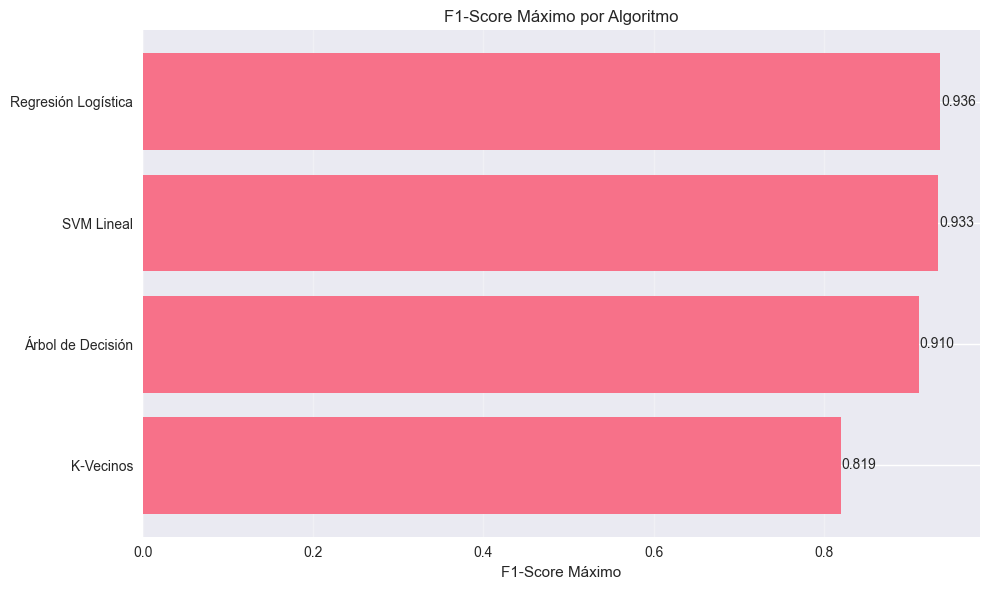

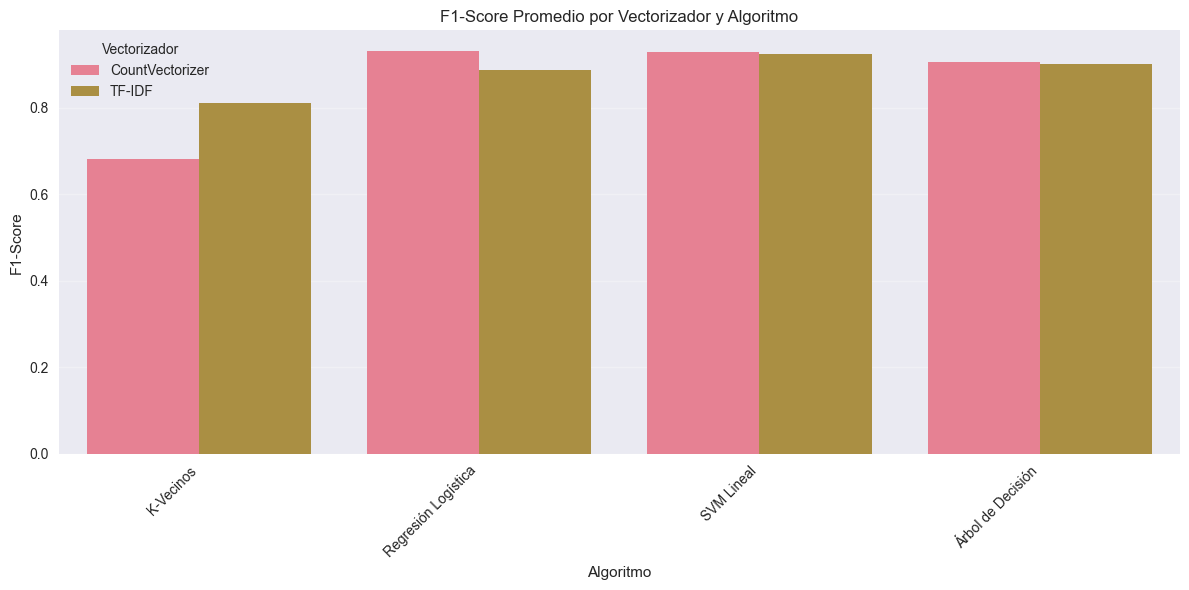

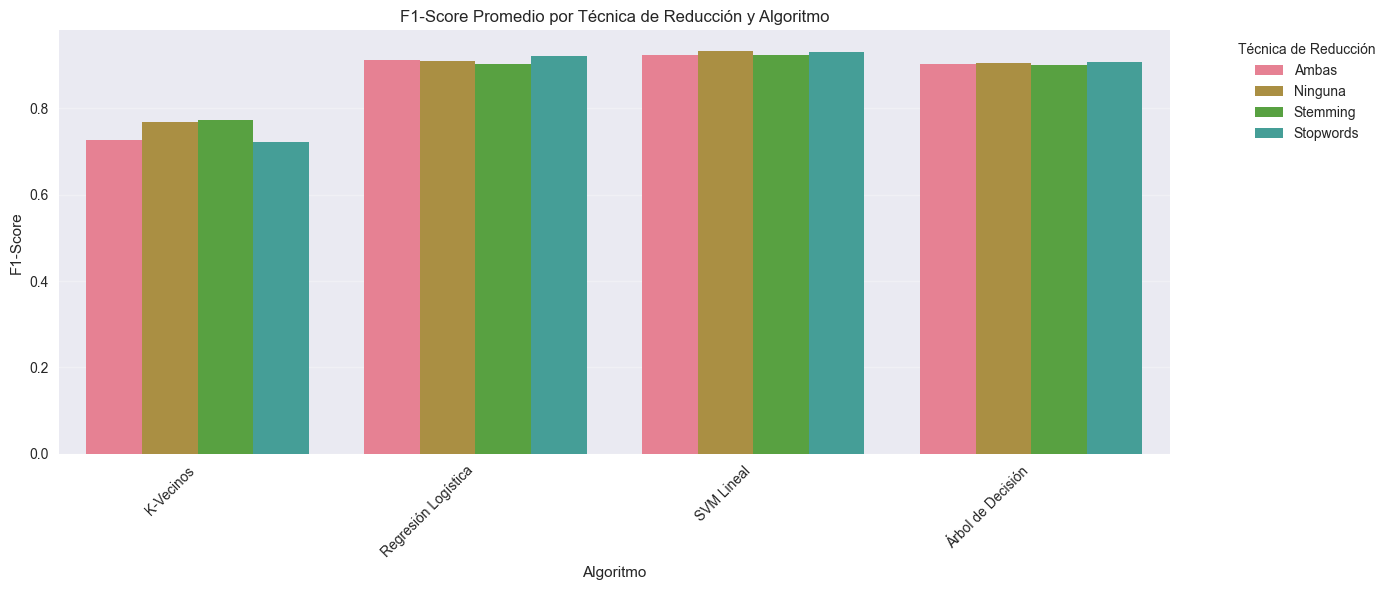

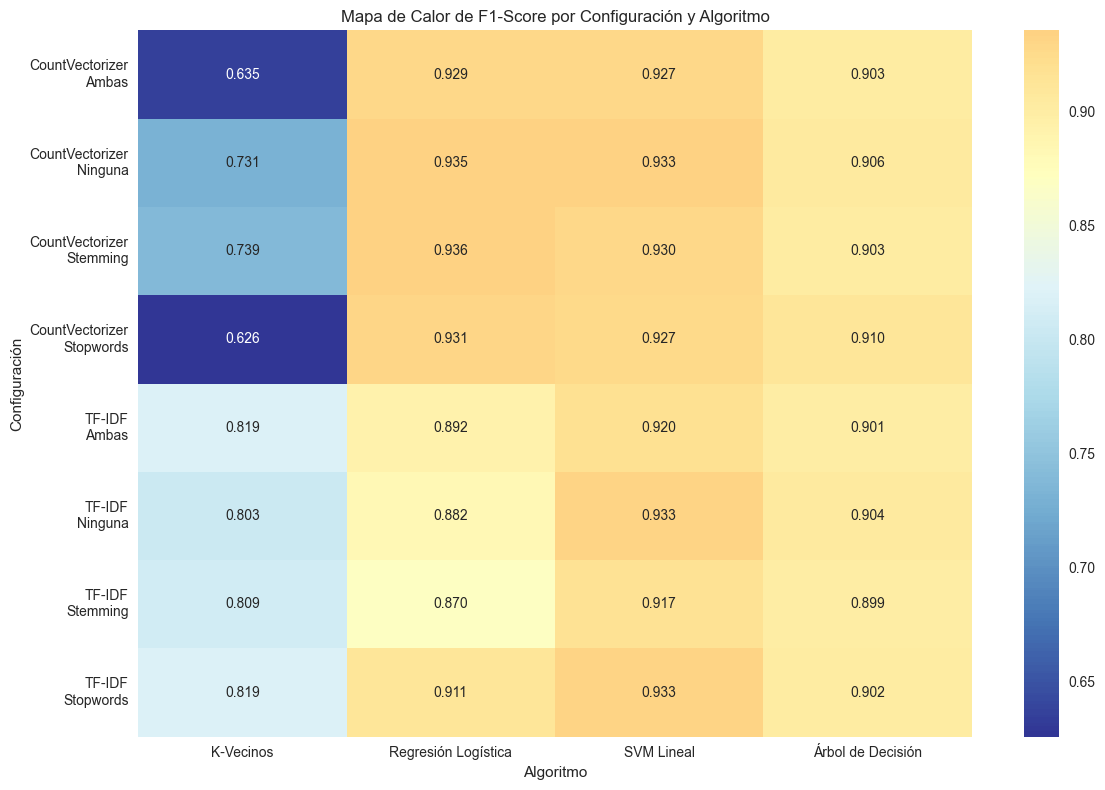

In [10]:
class ResultsVisualizer:
    """Visualizador de resultados de experimentos de machine learning"""
    
    def __init__(self, results_df: pd.DataFrame):
        self.results_df = results_df
        self.results_df = self._prepare_data()
    
    def _prepare_data(self) -> pd.DataFrame:
        """Prepara los datos para visualización"""
        df = self.results_df.copy()
        
        # Crear columna de técnica de reducción
        df["Técnica_Reducción"] = df.apply(
            lambda row: "Stopwords" if row["Stopwords"] and not row["Stemming"] else
                       "Stemming" if row["Stemming"] and not row["Stopwords"] else
                       "Ambas" if row["Stopwords"] and row["Stemming"] else
                       "Ninguna", axis=1
        )
        
        return df
    
    def plot_max_f1_by_algorithm(self, figsize: Tuple[int, int] = (10, 6)):
        """Gráfico de F1-Score máximo por algoritmo"""
        plt.figure(figsize=figsize)
        
        max_f1_data = self.results_df.groupby("Algoritmo")["F1-Score"].max().reset_index()
        max_f1_data = max_f1_data.sort_values("F1-Score", ascending=True)
        
        bars = plt.barh(max_f1_data["Algoritmo"], max_f1_data["F1-Score"])
        
        # Agregar valores en las barras
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center', fontsize=10)
        
        plt.xlabel("F1-Score Máximo")
        plt.title("F1-Score Máximo por Algoritmo")
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_mean_f1_by_vectorizer(self, figsize: Tuple[int, int] = (12, 6)):
        """Gráfico de F1-Score promedio por vectorizador y algoritmo"""
        plt.figure(figsize=figsize)
        
        mean_data = self.results_df.groupby(["Vectorizador", "Algoritmo"])["F1-Score"].mean().reset_index()
        
        sns.barplot(data=mean_data, x="Algoritmo", y="F1-Score", hue="Vectorizador")
        plt.title("F1-Score Promedio por Vectorizador y Algoritmo")
        plt.xticks(rotation=45, ha='right')
        plt.legend(title="Vectorizador")
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_mean_f1_by_reduction_technique(self, figsize: Tuple[int, int] = (14, 6)):
        """Gráfico de F1-Score promedio por técnica de reducción y algoritmo"""
        plt.figure(figsize=figsize)
        
        mean_data = self.results_df.groupby(["Técnica_Reducción", "Algoritmo"])["F1-Score"].mean().reset_index()
        
        sns.barplot(data=mean_data, x="Algoritmo", y="F1-Score", hue="Técnica_Reducción")
        plt.title("F1-Score Promedio por Técnica de Reducción y Algoritmo")
        plt.xticks(rotation=45, ha='right')
        plt.legend(title="Técnica de Reducción", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_performance_heatmap(self, metric: str = "F1-Score", figsize: Tuple[int, int] = (12, 8)):
        """Mapa de calor del rendimiento por configuración y algoritmo"""
        plt.figure(figsize=figsize)
        
        # Crear etiquetas de configuración
        config_labels = self.results_df.apply(
            lambda row: f"{row['Vectorizador']}\n{row['Técnica_Reducción']}", axis=1
        )
        
        # Crear matriz pivote
        pivot_data = self.results_df.pivot_table(
            values=metric, 
            index=config_labels, 
            columns="Algoritmo", 
            aggfunc='mean'
        )
        
        sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlBu_r', center=pivot_data.mean().mean())
        plt.title(f"Mapa de Calor de {metric} por Configuración y Algoritmo")
        plt.xlabel("Algoritmo")
        plt.ylabel("Configuración")
        plt.tight_layout()
        plt.show()
    
    def create_comprehensive_analysis(self):
        """Crea un análisis visual completo de los resultados"""
        print("Análisis Visual de Resultados")
        print("=" * 50)
        
        self.plot_max_f1_by_algorithm()
        self.plot_mean_f1_by_vectorizer()
        self.plot_mean_f1_by_reduction_technique()
        self.plot_performance_heatmap()

# Crear visualizaciones
visualizer = ResultsVisualizer(results_df)
visualizer.create_comprehensive_analysis()